In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

np.random.seed(1)
tf.set_random_seed(1)

%matplotlib inline

/Users/tsungmin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1. Function define

### Util function

In [2]:
def one_hot_encode(x, n_class):
    """
    One Hot encoding
    
    Inputs:
    - x: N smaple vector
    - n_class: Number of class
    
    Returns:
    - en_1hot: Encoding matrix shape of (n_smaple, n_class)
    """
    
    en_1hot = np.zeros([len(x), n_class])
    
    for idx, cat in enumerate(x):
        en_1hot[idx, cat] = 1

    return en_1hot

def next_batch(X, y, batch_size, shuffle=True):
    """
    Get next batch data
    
    Inputs: 
    - X: input data
    - y: input data label
    - batch_size: s
    
    Outputs tuple of batch data 
    - X_batch: batch sampled X 
    - y_batch: batch sampled y
    """
    
    n_sample = X.shape[0]
    n_batch = n_sample // batch_size
    n_batch = n_batch + 1 if (n_sample % n_batch) != 0 else n_batch 
    idx = np.array(range(n_sample))
    
    if shuffle:
        np.random.shuffle(idx)
        
    for b_idx in range(n_batch):
        start, end = b_idx * batch_size, (b_idx + 1) * batch_size
        if end >= n_sample:
            sample_idx = idx[start:]
        else:
            sample_idx = idx[start:end] 
        
        X_batch, y_batch = X[sample_idx, :], y[sample_idx, :]
        yield X_batch, y_batch


def xavier_initializer(n_inputs, n_outputs, shape):
    """
    xavier initizlize 
    
    Inputs:
    - n_inputs: Number of input neurons
    - n_outpus: Number of output neurons
    - shape: shape of output
    
    Returns:
    - output: array of shape 
    
    """
    
    init_range = np.sqrt(6.0 / ((n_inputs + n_outputs)))
    
    return  tf.random_uniform(shape, -init_range, init_range)


def get_output_size(input_size, ksize, n_filters, stride, pad):
    """
    Get output size of layer
    
    Inputs:
    - input_size: shape of input data
    - ksize: kernel size
    - n_filters: number of output channel
    - stride: Stride steps
    - pad: Pad steps
    
    Returns:
    - output_size: output size
    """

    NH, NW, ND = input_size
    KH, KW = ksize
    OH = (NH + 2 * pad - KH) // stride + 1
    OW = (NW + 2 * pad - KW) // stride + 1

    output_size = (OH, OW, n_filters)
    return output_size

## 2. Load data

### Data normalize

In [3]:
def std_norm(X, mu=None, sigma=None):
    """
    Standard normalize input data X with mu and sigma.
    If mu and sigma not given compute from input data X
    
    Inputs:
    - X: Input data of shape (N, H, W, C)
    
    Returns a tuple of:
    - X_sc: Standard normalize of X 
    - mu: Mean of x of shape
    - sigma: standard deviation of x of shape
    
    """
    
    if mu is None:
        mu = np.mean(X, axis=0, keepdims=True)
    X_sc = X - mu
    
    if sigma is None:
        sigma = np.std(X, axis=0, keepdims=True)
    X_sc = X_sc / sigma
    
    return X_sc, mu, sigma

In [4]:
X_train = np.load('exam2_train_x.npy')
y_train = np.load('exam2_train_y.npy')
y_train_en = one_hot_encode(y_train, 6)
X_train_sc, mu, sigma = std_norm(X_train)

In [5]:
X_test = np.load('exam2_test_x.npy')
y_test = np.load('exam2_test_y.npy')
y_test_en = one_hot_encode(y_test, 6)
X_test_sc, mu, sigama = std_norm(X_test, mu, sigma)

## 3.  Initialize parameters (Weights, bias for each layer)

In [6]:
def layer_init(layer, input_size, layer_type):
    """
    Initialize layer weights and its output size
    
    Inputs:
    - layer: Layer data structure in dictionary
    - input_size: Input size of layer
    - layer type: Layer type
    
    Returns:
    - output_size: Layer output shapes
    """
    
    output_size = None
    # only conv and fc layer need weights initialize
    if layer_type == 'conv':  
        
        NH, NW, ND = input_size
        params = layer['conv_params']
        stride = params['stride']
        padding = params['padding']
        KH, KW = params['ksize']
        KF = params['n_filters']
        
        # FIXME: pad should depend on ksize (KH, KW)
        if padding == 'SAME':
            pad = KH // 2
        else:
            pad = 0
        
        output_size = \
            get_output_size(input_size, (KH, KW), KF, stride, pad)
        
        # weights initialize
        n_inputs = KH * KW * ND
        n_outputs = KH * KW * KF
         
        w_shape = (KH, KW, ND, KF)
        w = tf.Variable(xavier_initializer(n_inputs, n_outputs, w_shape))
        b = tf.Variable(tf.zeros(KF))
        layer['w'], layer['b'] = w, b
        
        
    elif layer_type == 'pool':
        
        NH, NW, ND = input_size
        params = layer['pool_params']
        stride = params['stride']
        KH, KW = params['ksize']
        padding = params['padding']
        
        # FIXME: pad should depend on ksize (KH, KW)
        if padding == 'SAME':
            pad = KH // 2
        else:
            pad = 0
        
        output_size = \
            get_output_size(input_size, (KH, KW), ND, stride, pad)
                
    elif layer_type == 'fc':
        
        params = layer['params']
        n_inputs = np.prod(input_size)
        n_outputs = params['n_outputs']
        
        output_size = n_outputs
        
        # weights initialize
        w_shape = (n_inputs, n_outputs)
        w = tf.Variable(xavier_initializer(n_inputs, n_outputs, w_shape))
        b = tf.Variable(tf.zeros(n_outputs))
        layer['w'], layer['b'] = w, b

    # other layer
    else:
        output_size = input_size
            
    return output_size
            
def model_init(model, input_size):
    """
    Initialize the cnn model
    
    Inputs:
    - input_size: Input data size
    
    """
    for layer in model:
        layer_type = layer['name']
        for sub_layer in layer_type.split('_'):
            input_size = layer_init(layer, input_size, sub_layer)
        layer['output_size'] = input_size
        
    return model

In [7]:
model = [
{
    # Using '_' to define sandwish layer
    'name': 'conv_relu_pool',
    'conv_params': 
        { 'ksize': (3, 3), 'stride': 1, 'padding': 'SAME', 'n_filters': 8,
          'l2_reg': 1e-3 },
    'pool_params':
        { 'ksize': (2, 2), 'stride': 2, 'padding': 'VALID' },
},
{   
    'name': 'conv_relu_pool',
    'conv_params': 
        { 'ksize': (3, 3), 'stride': 1, 'padding': 'SAME', 'n_filters': 16,
          'l2_reg': 1e-3 },
    'pool_params': 
        { 'ksize': (2, 2), 'stride': 2, 'padding': 'VALID' },
},
# {
#     'name': 'dropout',
#     'params' : { 'keep_prob': 0.2 }
# },
{   
    'name': 'conv_relu_pool',
    'conv_params': 
        { 'ksize': (3, 3), 'stride': 1, 'padding': 'SAME', 'n_filters': 32,
          'l2_reg': 1e-3 },
    'pool_params': 
        { 'ksize': (2, 2), 'stride': 2, 'padding': 'VALID' },
},
{   
    'name': 'conv_relu_pool',
    'conv_params': 
        { 'ksize': (3, 3), 'stride': 1, 'padding': 'SAME', 'n_filters': 64,
          'l2_reg': 1e-3 },
    'pool_params': 
        { 'ksize': (2, 2), 'stride': 2, 'padding': 'VALID' },
},
{
    'name': 'dropout',
    'params' : { 'keep_prob': 0.2 }
},
# {   
#     'name': 'conv_relu_pool',
#     'conv_params': 
#         { 'ksize': (3, 3), 'stride': 1, 'padding': 'SAME', 'n_filters': 128,
#           'l2_reg': 1e-2 },
#     'pool_params': 
#         { 'ksize': (2, 2), 'stride': 2, 'padding': 'VALID' },
# },
{
    'name': 'fc_relu',
    'params':  { 'n_outputs': 128, 'l2_reg': 1e-3 },
},
{    
    'name': 'fc', #'fc_sigmoid',
    'params': { 'n_outputs': 6, 'l2_reg': 1e-3 },
},
]

In [8]:
input_size = (64, 64, 3)
model = model_init(model, input_size)

## 4.  Optimization of Convolution Neural Network model

In [9]:
def model_summary(model, input_size):
    """
    Show the model layer infomation
    
    Inputs: 
    - model: CNN mode 
    - input_size: input size of model
    
    """
    
    msg_format = \
        '{type:10s} | {sz:12s} | {ksize:12s} | {stride:6s} | {padding:7s} | {l2_reg:6s}'
            
    msg_header = {
            'type': 'Type', 'sz': 'Output Size', 'ksize': 'Kernel Size',
            'stride': 'Stride', 'padding': 'Padding', 'l2_reg': 'L2 reg'
    }
    
    def layer_summary(input_size, layer, layer_type):
        """
        Show layer information
        
        Inputs:
        - input_size: niput size of layer
        - layer: layer config 
        - layer_type: layer type
        """
        
        layer_info = {
            'type': '', 
            'sz': '', 'chs': '', 'ksize': '',
            'stride': '', 'padding': '',
            'l2_reg': '',
        }
        
        output_size = None
        
        if layer_type == 'conv':
            
            NH, NW, ND = input_size
            params = layer['conv_params']
            stride = params['stride']
            padding = params['padding']
            KH, KW = params['ksize']
            KF = params['n_filters']
            
            # FIXME: pad should depend on ksize (KH, KW)
            if padding == 'SAME':
                pad = KH // 2
            else:
                pad = 0
            
            channel = KF
            
            output_size = \
                get_output_size(input_size, [KH, KW], KF, stride, pad)
            
            layer_info['sz'] = str(output_size)
            layer_info['ksize'] = str(params['ksize'])
            layer_info['stride'] = str(stride)
            layer_info['padding'] = padding
            
            if 'l2_reg' in params:
                layer_info['l2_reg'] = str('{:.1e}'.format(params['l2_reg']))
            
        elif layer_type == 'pool':
            
            NH, NW, ND = input_size
            params = layer['pool_params']
            stride = params['stride']
            padding = params['padding']
            KH, KW = params['ksize']
            channel = ND
            
            # FIXME: pad should depend on ksize (KH, KW)
            if padding == 'SAME':
                pad = KH // 2
            else:
                pad = 0
            
            output_size = \
                get_output_size(input_size, [KH, KW], ND, stride, pad)
            
            layer_info['sz'] = str(output_size)
            layer_info['ksize'] = str((KH, KW))
            layer_info['stride'] = str(stride)
            layer_info['padding'] = padding
            
        elif layer_type == 'fc':
            
            params = layer['params']
            output_size = params['n_outputs']
            
            layer_info['sz'] = str(output_size)
            
            if 'l2_reg' in params:
                layer_info['l2_reg'] = str('{:.1e}'.format(params['l2_reg']))
            
        else:
            
            output_size = input_size
            layer_info['sz'] = str(output_size)
        
        layer_info['type'] = layer_type
        print(msg_format.format(**layer_info))
        
        return output_size
    
    print(msg_format.format(**msg_header))
    print('-'*len(msg_format))
    for layer in model:
        layer_type = layer['name']
        sub_layers = layer_type.split('_')
        
        for sub_layer in sub_layers:
            output_size = layer_summary(input_size, layer, sub_layer)
            input_size = output_size

In [10]:
def build_layer(input_, layer, layer_type, training):
    """
    Build layer operations
    
    Inputs:
    - input_: input tensor for layer
    - layer: layer config
    - layer_type: layer type
    
    Return:
    - output: output tensor for layer
    """
    
    output = None
    if layer_type == 'conv':
        
        params = layer['conv_params']
        w = layer['w']
        b = layer['b']
        KH, KW = params['ksize']
        stride = params['stride']
        padding = params['padding']
        
        conv = tf.nn.conv2d(input_, w, 
                            strides=(1, stride, stride, 1), padding=padding)
        output = tf.nn.bias_add(conv, b)
        
        
    elif layer_type == 'pool':
        
        params = layer['pool_params']
        
        KH, KW = params['ksize']
        stride = params['stride']
        padding = params['padding']
        
        output = tf.nn.max_pool(input_,
                                ksize=(1, KH, KW , 1),
                                strides=(1, stride, stride, 1), padding=padding)
    
    elif layer_type == 'fc':
        
        w = layer['w']
        b = layer['b']
        
        shape = input_.get_shape().as_list()
        dim = np.prod(shape[1:])            
        flatten = tf.reshape(input_, [-1, dim])
        
        output = tf.matmul(flatten, w) + b
        
    elif layer_type == 'dropout':
        
        params = layer['params']
        keep_prob = params['keep_prob']
        
        #output = tf.nn.dropout(input_, keep_prob)
        output = tf.layers.dropout(input_, 1. - keep_prob, training=training)
        
    elif layer_type == 'relu':
        
        output = tf.nn.relu(input_)
        
    elif layer_type == 'sigmoid':
        
        output = tf.nn.sigmoid(input_)
    
    return output

def build_model(model, X, y, training):
    """
    Build model operation
    
    Inputs:
    - model: CNN model layer 
    - X: tf placeholder
    - y: tf placeholder
    
    Returns a tuple of tensorflow graph op:
    - loss_: model loss
    - pred: model prediction
    - acc: model accuracy
    """
    
    input_ = X
    for layer in model:
        layer_type = layer['name']
        sub_layers = layer_type.split('_')
        
        for sub_layer in sub_layers:
            output = build_layer(input_, layer, sub_layer, training)
            input_ = output
            
    # compute loss
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=y)
    loss = tf.reduce_mean(cross_entropy)
    
    # regularization
    for layer in model:
        layer_type = layer['name']
        sub_layers = layer_type.split('_')
        
        # TODO: refactor me
        for sub_layer in sub_layers:
            if sub_layer == 'conv':
                params = layer['conv_params']
                if 'l2_reg' in params:
                    alpha = params['l2_reg']
                    loss += (alpha * tf.nn.l2_loss(layer['w']))
                
            elif sub_layer == 'fc':
                params = layer['params']
                if 'l2_reg' in params:
                    alpha = params['l2_reg']
                    loss += (alpha * tf.nn.l2_loss(layer['w']))
            
    # prediction
    pred = tf.argmax(tf.nn.softmax(output), axis=-1) 
    
    # accuracy
    correct_pred = tf.equal(tf.argmax(y, axis=-1), pred)
    correct_pred = tf.cast(correct_pred, tf.float32)
    acc = tf.reduce_mean(correct_pred)
    
    return loss, pred, acc
    

In [11]:
def model_optimize(model, sess, config, X, y, training):
    """
    Run model optimization
    
    Inputs:
    - model: CNN model
    - sess: tensroflow graph session
    - config: optimization config
    - X: image input tensorflow tensor
    - y: label input tensorflow tensor
    
    Returns:
    - model: optimized CNN model
    - loss_history: loss history
    """
    
    # config
    Xs, ys = config['train_data']
    X_test_sc, y_test_en = config['test_data']
    batch_size = config['batch_size']
    epochs = config['epochs']
    
    train_op = config['train_op']
    loss_op = config['loss_op']
    pred_op = config['pred_op']
    
    loss_history = []
    
    for e in range(epochs):
   
        batch_loss = []
        batch_acc = []
        
        for X_batch, y_batch in next_batch(Xs, ys, batch_size): 
            _, loss = sess.run([train_op, loss_op], 
                               feed_dict = { X: X_batch, y: y_batch, training: True})
            acc = sess.run(acc_op, feed_dict={ X: X_batch, y: y_batch, training: False })
            
            batch_loss.append(loss)
            batch_acc.append(acc)
            
        avg_loss = np.mean(batch_loss)
        avg_acc = np.mean(batch_acc)
        
        loss_history.append(avg_loss)
        
        #test_acc = sess.run(acc_op, feed_dict = { X: X_test_sc, y: y_test_en, training: False })
        if (e + 1) % 5 == 0:
            print('[{:3d}|{:3d}] avg loss: {:.4f} avg acc: {:.4f}'.format(
                e + 1, epochs, avg_loss, avg_acc * 100))    
        
        # ugly early stop 
        #if test_acc  > 0.96:
        #    break
        
        
    return model, loss_history

In [12]:
epochs = 50
batch_size = 64
learning_rate = 1e-3

# tf placeholder
X_feed = tf.placeholder(tf.float32, (None, 64, 64, 3))
y_feed = tf.placeholder(tf.float32, (None, 6))
training = tf.placeholder(tf.bool)
    
# prepare operations 
loss_op, pred_op, acc_op = build_model(model, X_feed, y_feed, training)
adam = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = adam.minimize(loss_op)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [13]:
input_size = (64, 64, 3)
model_summary(model, input_size)

Type       | Output Size  | Kernel Size  | Stride | Padding | L2 reg
------------------------------------------------------------------------------
conv       | (64, 64, 8)  | (3, 3)       | 1      | SAME    | 1.0e-03
relu       | (64, 64, 8)  |              |        |         |       
pool       | (32, 32, 8)  | (2, 2)       | 2      | VALID   |       
conv       | (32, 32, 16) | (3, 3)       | 1      | SAME    | 1.0e-03
relu       | (32, 32, 16) |              |        |         |       
pool       | (16, 16, 16) | (2, 2)       | 2      | VALID   |       
conv       | (16, 16, 32) | (3, 3)       | 1      | SAME    | 1.0e-03
relu       | (16, 16, 32) |              |        |         |       
pool       | (8, 8, 32)   | (2, 2)       | 2      | VALID   |       
conv       | (8, 8, 64)   | (3, 3)       | 1      | SAME    | 1.0e-03
relu       | (8, 8, 64)   |              |        |         |       
pool       | (4, 4, 64)   | (2, 2)       | 2      | VALID   |       
dropout    | (4, 4, 

[  5| 50] avg loss: 1.1968 avg acc: 72.9167
[ 10| 50] avg loss: 0.7891 avg acc: 92.5000
[ 15| 50] avg loss: 0.5817 avg acc: 96.0417
[ 20| 50] avg loss: 0.5165 avg acc: 98.3333
[ 25| 50] avg loss: 0.4090 avg acc: 99.0625
[ 30| 50] avg loss: 0.3893 avg acc: 99.3750
[ 35| 50] avg loss: 0.3396 avg acc: 99.6875
[ 40| 50] avg loss: 0.3010 avg acc: 99.5833
[ 45| 50] avg loss: 0.3045 avg acc: 99.7917
[ 50| 50] avg loss: 0.2409 avg acc: 99.8958
Train accuracy 99.9020
Test accuracy 97.2222


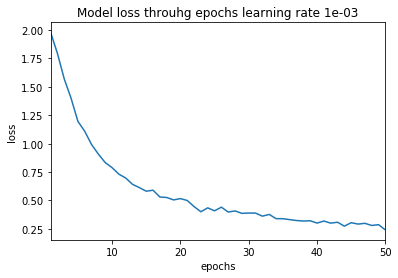

In [14]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    config = { 
        'epochs': epochs,
        'batch_size': batch_size,
        'train_data': (X_train_sc, y_train_en),
        'test_data': (X_test_sc, y_test_en),

        # ops
        'train_op': train_op,
        'loss_op': loss_op,
        'pred_op': pred_op,
        'acc_op': acc_op
    }
    
    model, loss_hist = model_optimize(model, sess, config, X_feed, y_feed, training)
    
    plt.title('Model loss throuhg epochs learning rate {:1.0e}'.format(learning_rate))
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.plot(np.arange(1, len(loss_hist) + 1), loss_hist)
    plt.xlim(xmin=1, xmax=len(loss_hist))

    train_acc = sess.run(acc_op, feed_dict={ X_feed: X_train_sc ,y_feed: y_train_en, training: False })
    print('Train accuracy {:4.4f}'.format(train_acc * 100))
    
    test_acc = sess.run(acc_op, feed_dict={ X_feed: X_test_sc, y_feed: y_test_en, training: False })
    print('Test accuracy {:4.4f}'.format(test_acc * 100))